In [1]:
import os
import glob
import gzip
from collections import defaultdict
import pysam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import cdist
from sklearn import metrics
from statsmodels.stats.multitest import multipletests

sns.set_style("darkgrid")
sns.set_context("notebook")
sns.set_palette("deep")


# SNV Benchmark

## Comparative analysis

### Sensitivity, Precision, and F1


In [2]:
sample_ids = pd.read_csv("sample_ids.csv")


def read_summary(file_path):
    try:
        with open(file_path, "r") as f:
            lines = f.readlines()

        none_line = next(
            (line for line in lines if line.strip().startswith("None")), None
        )

        if none_line:
            values = none_line.split()
            metrics = {
                "True-pos-baseline": int(values[1]),
                "True-pos-call": int(values[2]),
                "False-pos": int(values[3]),
                "False-neg": int(values[4]),
                "Precision": float(values[5]),
                "Sensitivity": float(values[6]),
                "F-measure": float(values[7]),
            }
            return metrics
        else:
            print(f"No 'None' threshold line found in {file_path}")
            return {}
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return {}
    except Exception as e:
        print(f"Error reading file {file_path}: {str(e)}")
        return {}


def calculate_rtg_statistics(df):
    return df.groupby("complexity").agg(
        {
            "Precision": ["mean", "std", "median", "min", "max"],
            "Sensitivity": ["mean", "std", "median", "min", "max"],
            "F-measure": ["mean", "std", "median", "min", "max"],
        }
    )


snv_ont_hc_metrics = []
snv_ont_lc_metrics = []
snv_illumina_hc_metrics = []
snv_illumina_lc_metrics = []

complexities = ["hc", "lc"]
technologies = ["ont", "illumina"]

for _, row in sample_ids.iterrows():
    ont_id = row["ont_id"]
    lp_id = row["lp_id"]

    for tech in technologies:
        for complexity in complexities:
            sample_id = ont_id if tech == "ont" else lp_id
            summary_file = (
                f"output/snv/rtg_vcfeval/{complexity}/{sample_id}.snv/summary.txt"
            )
            summary = read_summary(summary_file)

            if summary:
                metrics_entry = {
                    "sample_id": sample_id,
                    "complexity": complexity,
                    **summary,
                }

                if tech == "ont":
                    if complexity == "hc":
                        snv_ont_hc_metrics.append(metrics_entry)
                    else:
                        snv_ont_lc_metrics.append(metrics_entry)
                elif tech == "illumina":
                    if complexity == "hc":
                        snv_illumina_hc_metrics.append(metrics_entry)
                    else:
                        snv_illumina_lc_metrics.append(metrics_entry)
            else:
                print(f"Skipping empty summary for {sample_id}, {tech}, {complexity}")


snv_ont_metrics_df = pd.DataFrame(snv_ont_hc_metrics + snv_ont_lc_metrics)
snv_illumina_metrics_df = pd.DataFrame(
    snv_illumina_hc_metrics + snv_illumina_lc_metrics
)

snv_ont_stats = calculate_rtg_statistics(snv_ont_metrics_df)
snv_illumina_stats = calculate_rtg_statistics(snv_illumina_metrics_df)

snv_ont_stats


Precision                                    Sensitivity            \
                mean       std   median     min     max        mean       std   
complexity                                                                      
hc          0.953193  0.010021  0.95525  0.9280  0.9626    0.954971  0.018307   
lc          0.783021  0.013049  0.78540  0.7544  0.7987    0.744514  0.016510   

                                    F-measure                             \
             median     min     max      mean       std   median     min   
complexity                                                                 
hc          0.96345  0.9132  0.9698  0.954064  0.014057  0.95975  0.9205   
lc          0.75045  0.7065  0.7600  0.763257  0.014630  0.76830  0.7296   

                    
               max  
complexity          
hc          0.9662  
lc          0.7776

In [3]:
snv_illumina_stats


Precision                                    Sensitivity            \
                mean       std   median     min     max        mean       std   
complexity                                                                      
hc          0.962943  0.003552  0.96495  0.9545  0.9663    0.972471  0.000851   
lc          0.799429  0.004806  0.80085  0.7882  0.8045    0.743236  0.002270   

                                    F-measure                            \
             median     min     max      mean       std  median     min   
complexity                                                                
hc          0.97285  0.9706  0.9736  0.967693  0.002114  0.9689  0.9625   
lc          0.74315  0.7388  0.7462  0.770307  0.003016  0.7706  0.7627   

                    
               max  
complexity          
hc          0.9696  
lc          0.7737

In [4]:
def perform_ttest(ont_data, illumina_data, metric):
    ont_values = ont_data[metric]
    illumina_values = illumina_data[metric]
    t_stat, p_value = stats.ttest_ind(ont_values, illumina_values)
    return t_stat, p_value


metrics_to_test = ["Precision", "Sensitivity", "F-measure"]

for df in [snv_ont_stats, snv_illumina_stats]:
    for metric in metrics_to_test:
        df[(metric, "t_statistic")] = None
        df[(metric, "p_value")] = None
        df[(metric, "adjusted_p_value")] = None

all_p_values = []

for complexity in complexities:
    ont_data = snv_ont_metrics_df[snv_ont_metrics_df["complexity"] == complexity]
    illumina_data = snv_illumina_metrics_df[
        snv_illumina_metrics_df["complexity"] == complexity
    ]

    for metric in metrics_to_test:
        t_stat, p_value = perform_ttest(ont_data, illumina_data, metric)

        snv_ont_stats.loc[complexity, (metric, "t_statistic")] = t_stat
        snv_ont_stats.loc[complexity, (metric, "p_value")] = p_value

        snv_illumina_stats.loc[complexity, (metric, "t_statistic")] = t_stat
        snv_illumina_stats.loc[complexity, (metric, "p_value")] = p_value

        all_p_values.append(p_value)

# Perform FDR correction
_, adjusted_p_values, _, _ = multipletests(all_p_values, method="fdr_bh")

adjusted_p_value_index = 0
for complexity in complexities:
    for metric in metrics_to_test:
        adjusted_p_value = adjusted_p_values[adjusted_p_value_index]
        snv_ont_stats.loc[complexity, (metric, "adjusted_p_value")] = adjusted_p_value
        snv_illumina_stats.loc[complexity, (metric, "adjusted_p_value")] = (
            adjusted_p_value
        )
        adjusted_p_value_index += 1

print("ONT SNV Stats:")
snv_ont_stats


ONT SNV Stats:


Precision                                    Sensitivity            \
                mean       std   median     min     max        mean       std   
complexity                                                                      
hc          0.953193  0.010021  0.95525  0.9280  0.9626    0.954971  0.018307   
lc          0.783021  0.013049  0.78540  0.7544  0.7987    0.744514  0.016510   

                                     ... F-measure   Precision            \
             median     min     max  ...       max t_statistic   p_value   
complexity                           ...                                   
hc          0.96345  0.9132  0.9698  ...    0.9662   -3.431387  0.002018   
lc          0.75045  0.7065  0.7600  ...    0.7776   -4.414588  0.000158   

                            Sensitivity                             \
           adjusted_p_value t_statistic   p_value adjusted_p_value   
complexity                                                           
hc                 0.003028   -3.572853  0.001409         0.002818   
lc                 0.000945    0.287054  0.776346         0.776346   

             F-measure                             
           t_statistic   p_value adjusted_p_value  
complexity                                         
hc           -3.587257  0.001358         0.002818  
lc            -1.76588  0.089158          0.10699  

[2 rows x 24 columns]

In [5]:
print("\nIllumina SNV Stats:")
snv_illumina_stats



Illumina SNV Stats:


Precision                                    Sensitivity            \
                mean       std   median     min     max        mean       std   
complexity                                                                      
hc          0.962943  0.003552  0.96495  0.9545  0.9663    0.972471  0.000851   
lc          0.799429  0.004806  0.80085  0.7882  0.8045    0.743236  0.002270   

                                     ... F-measure   Precision            \
             median     min     max  ...       max t_statistic   p_value   
complexity                           ...                                   
hc          0.97285  0.9706  0.9736  ...    0.9696   -3.431387  0.002018   
lc          0.74315  0.7388  0.7462  ...    0.7737   -4.414588  0.000158   

                            Sensitivity                             \
           adjusted_p_value t_statistic   p_value adjusted_p_value   
complexity                                                           
hc                 0.003028   -3.572853  0.001409         0.002818   
lc                 0.000945    0.287054  0.776346         0.776346   

             F-measure                             
           t_statistic   p_value adjusted_p_value  
complexity                                         
hc           -3.587257  0.001358         0.002818  
lc            -1.76588  0.089158          0.10699  

[2 rows x 24 columns]

### Error Analysis


[W::hts_idx_load3] The index file is older than the data file: output/snv/rtg_vcfeval/hc/A046_12.snv/tp.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: output/snv/rtg_vcfeval/hc/A048_09.snv/tp.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: output/snv/rtg_vcfeval/hc/A085_00.snv/tp.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: output/snv/rtg_vcfeval/hc/A153_01.snv/tp.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: output/snv/rtg_vcfeval/hc/A154_04.snv/tp.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: output/snv/rtg_vcfeval/hc/LP6008462-DNA_A09.snv/tp.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: output/snv/rtg_vcfeval/hc/LP6008463-DNA_F04.snv/tp.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: output/snv/rtg_vcfeval/hc/LP6008463-DNA_H09.snv/tp.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than th

<Figure size 2000x1000 with 0 Axes>

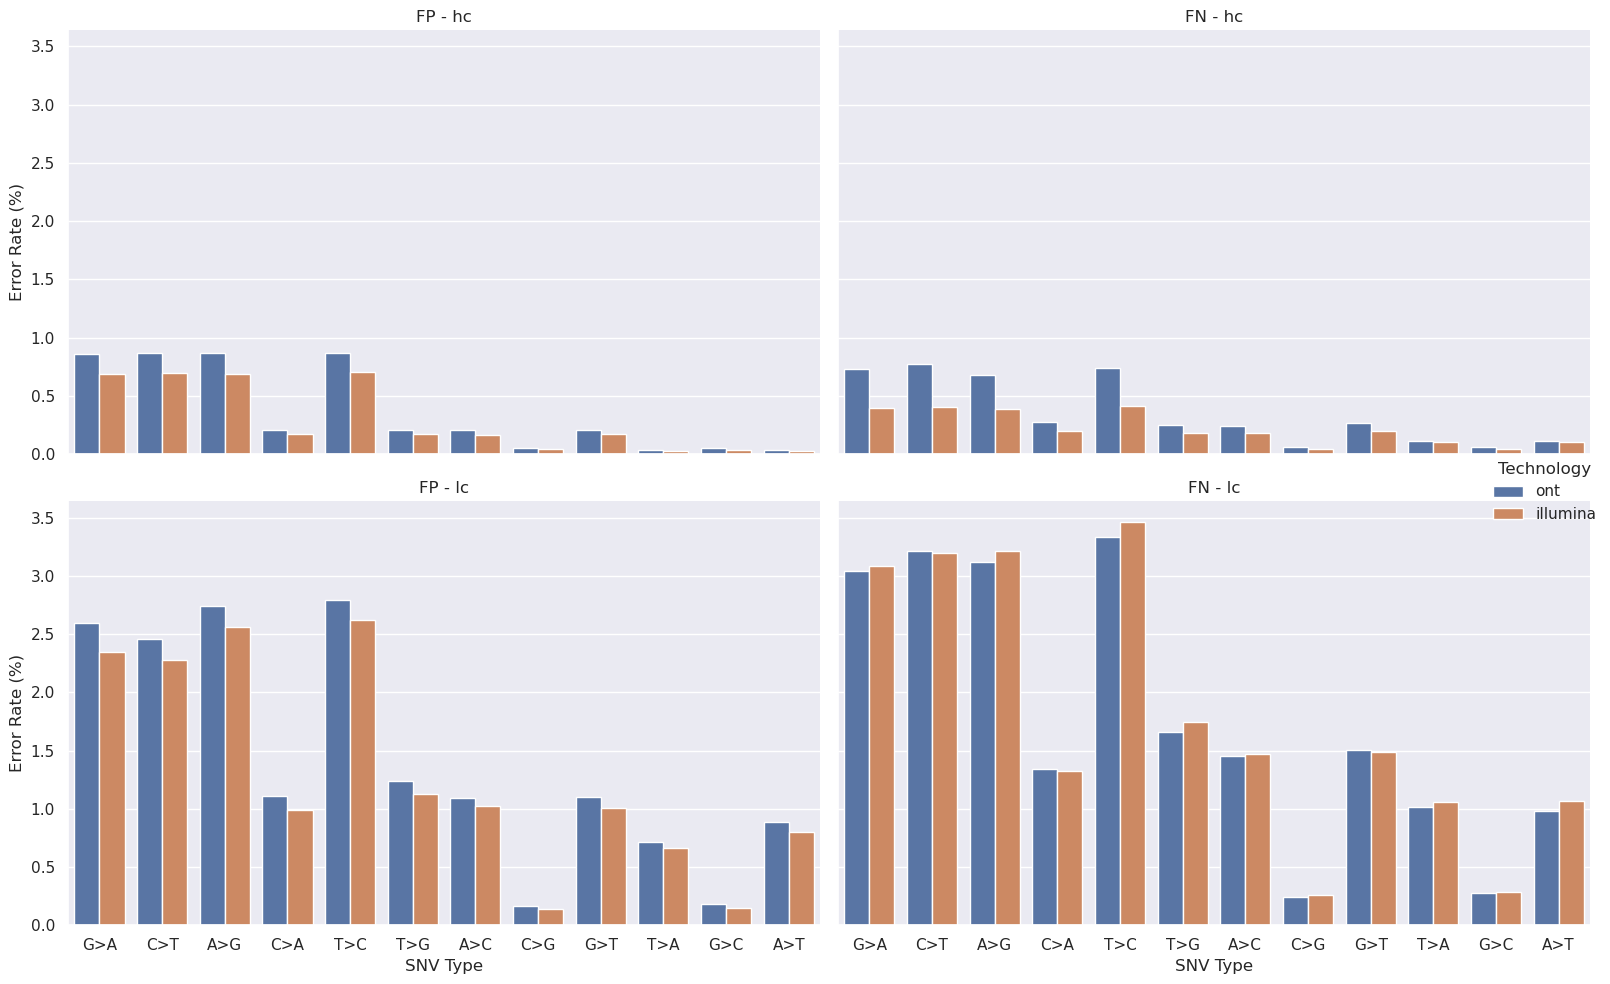

In [6]:
def analyze_snv_errors(technology, complexity, sample_ids):
    error_types = defaultdict(lambda: defaultdict(int))
    total_variants = 0
    fn_count = 0

    for _, row in sample_ids.iterrows():
        sample_id = row["ont_id"] if technology == "ont" else row["lp_id"]
        base_path = f"output/snv/rtg_vcfeval/{complexity}/{sample_id}.snv"

        fp_file = os.path.join(base_path, "fp.vcf.gz")
        fn_file = os.path.join(base_path, "fn.vcf.gz")
        tp_file = os.path.join(base_path, "tp.vcf.gz")

        with pysam.VariantFile(tp_file) as vcf:
            total_variants += sum(1 for _ in vcf)

        with pysam.VariantFile(fp_file) as vcf:
            for record in vcf:
                ref = record.ref
                alt = record.alts[0]
                error_types["FP"][f"{ref}>{alt}"] += 1
                total_variants += 1

        with pysam.VariantFile(fn_file) as vcf:
            for record in vcf:
                ref = record.ref
                alt = record.alts[0]
                error_types["FN"][f"{ref}>{alt}"] += 1
                fn_count += 1

    total_variants += fn_count

    return error_types, total_variants


snv_error_data = {}
snv_total_variants_data = {}

for tech in technologies:
    for comp in complexities:
        snv_error_data[f"{tech}_{comp}"], snv_total_variants_data[f"{tech}_{comp}"] = (
            analyze_snv_errors(tech, comp, sample_ids)
        )

snv_plot_data = []
for tech_comp, error_data in snv_error_data.items():
    tech, comp = tech_comp.split("_")
    total_variants = snv_total_variants_data[tech_comp]
    for error_type, snv_types in error_data.items():
        for snv_type, count in snv_types.items():
            error_rate = (count / total_variants) * 100
            snv_plot_data.append(
                {
                    "Technology": tech,
                    "Complexity": comp,
                    "Error Type": error_type,
                    "SNV Type": snv_type,
                    "Error Rate (%)": error_rate,
                }
            )

snv_plot_df = pd.DataFrame(snv_plot_data)

plt.figure(figsize=(20, 10))
g = sns.catplot(
    data=snv_plot_df,
    x="SNV Type",
    y="Error Rate (%)",
    hue="Technology",
    col="Error Type",
    row="Complexity",
    kind="bar",
    height=5,
    aspect=1.5,
    legend=True,
)
g.set_axis_labels("SNV Type", "Error Rate (%)")
g.set_titles("{col_name} - {row_name}")
g.fig.subplots_adjust(right=0.85)
handles, labels = g.axes[0, 0].get_legend_handles_labels()
plt.tight_layout()
plt.show()
plt.close()


In [7]:
for tech_comp, total in snv_total_variants_data.items():
    tech, comp = tech_comp.split("_")
    print(f"{tech.upper()} - {comp.upper()}: Total SNV variants = {total}")


ONT - HC: Total SNV variants = 9553039
ONT - LC: Total SNV variants = 490420
ILLUMINA - HC: Total SNV variants = 9467513
ILLUMINA - LC: Total SNV variants = 482390


In [8]:
def perform_statistical_test(
    ont_data, illumina_data, ont_total, illumina_total, error_type, snv_type
):
    ont_error = ont_data[error_type].get(snv_type, 0)
    illumina_error = illumina_data[error_type].get(snv_type, 0)

    contingency_table = [
        [ont_error, ont_total - ont_error],
        [illumina_error, illumina_total - illumina_error],
    ]

    if any(any(cell < 5 for cell in row) for row in contingency_table):
        _, p_value = stats.fisher_exact(contingency_table)
    else:
        chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)

    return p_value


results = []

for comp in complexities:
    ont_data = snv_error_data[f"ont_{comp}"]
    illumina_data = snv_error_data[f"illumina_{comp}"]
    ont_total = snv_total_variants_data[f"ont_{comp}"]
    illumina_total = snv_total_variants_data[f"illumina_{comp}"]

    for error_type in ["FP", "FN"]:
        snv_types = set(ont_data[error_type].keys()) | set(
            illumina_data[error_type].keys()
        )

        for snv_type in snv_types:
            p_value = perform_statistical_test(
                ont_data, illumina_data, ont_total, illumina_total, error_type, snv_type
            )
            ont_rate = ont_data[error_type].get(snv_type, 0) / ont_total * 100
            illumina_rate = (
                illumina_data[error_type].get(snv_type, 0) / illumina_total * 100
            )

            results.append(
                {
                    "Complexity": comp,
                    "Error Type": error_type,
                    "SNV Type": snv_type,
                    "ONT Rate (%)": ont_rate,
                    "Illumina Rate (%)": illumina_rate,
                    "p-value": p_value,
                }
            )

results_df = pd.DataFrame(results)

# Perform FDR correction
_, p_values_corrected, _, _ = multipletests(results_df["p-value"], method="fdr_bh")
results_df["Adjusted p-value"] = p_values_corrected

results_df = results_df.sort_values(["Complexity", "Error Type", "SNV Type"])

results_df["ONT Rate (%)"] = results_df["ONT Rate (%)"].map("{:.4f}".format)
results_df["Illumina Rate (%)"] = results_df["Illumina Rate (%)"].map("{:.4f}".format)
results_df["p-value"] = results_df["p-value"].map("{:.4e}".format)
results_df["Adjusted p-value"] = results_df["Adjusted p-value"].map("{:.4e}".format)

results_df["Significance"] = results_df["Adjusted p-value"].apply(
    lambda x: (
        "***"
        if float(x) < 0.001
        else ("**" if float(x) < 0.01 else ("*" if float(x) < 0.05 else ""))
    )
)

print("Statistical test results for SNVs:")
print(results_df.to_string(index=False))


Statistical test results for SNVs:
Complexity Error Type SNV Type ONT Rate (%) Illumina Rate (%)     p-value Adjusted p-value Significance
        hc         FN      A>C       0.2421            0.1839 9.3521e-167      3.7409e-166          ***
        hc         FN      A>G       0.6797            0.3864  0.0000e+00       0.0000e+00          ***
        hc         FN      A>T       0.1095            0.1033  4.0110e-05       5.8342e-05          ***
        hc         FN      C>A       0.2724            0.1986 2.2509e-241      1.2005e-240          ***
        hc         FN      C>G       0.0591            0.0400  7.5094e-78       2.1203e-77          ***
        hc         FN      C>T       0.7695            0.4069  0.0000e+00       0.0000e+00          ***
        hc         FN      G>A       0.7338            0.3985  0.0000e+00       0.0000e+00          ***
        hc         FN      G>C       0.0616            0.0435  1.9524e-66       5.2063e-66          ***
        hc         FN      G>

# Indel Benchmark

## Comparative analysis

### Sensitivity, Precision, and F1


In [9]:
indel_metrics = []

complexities = ["hc", "lc"]

for _, row in sample_ids.iterrows():
    ont_id = row["ont_id"]

    for complexity in complexities:
        summary_file = (
            f"output/indel/rtg_vcfeval/{complexity}/{ont_id}.indel/summary.txt"
        )
        summary = read_summary(summary_file)

        if summary:
            metrics_entry = {
                "sample_id": ont_id,
                "complexity": complexity,
                **summary,
            }
            indel_metrics.append(metrics_entry)
        else:
            print(f"Skipping empty summary for {ont_id}, {complexity}")

indel_metrics_df = pd.DataFrame(indel_metrics)
indel_stats = calculate_rtg_statistics(indel_metrics_df)

print("Indel Stats:")
indel_stats


Indel Stats:


Precision                                    Sensitivity            \
                mean       std   median     min     max        mean       std   
complexity                                                                      
hc          0.806957  0.054459  0.82230  0.7153  0.8729    0.898500  0.039479   
lc          0.516743  0.046962  0.52375  0.4477  0.5838    0.403386  0.050544   

                                    F-measure                             \
             median     min     max      mean       std   median     min   
complexity                                                                 
hc          0.91485  0.8152  0.9374  0.850136  0.047592  0.86610  0.7623   
lc          0.41335  0.3197  0.4741  0.452936  0.049965  0.46205  0.3730   

                    
               max  
complexity          
hc          0.9039  
lc          0.5232

### Error Analysis


In [10]:
def analyze_indel_errors(complexity, sample_ids):
    error_types = defaultdict(lambda: defaultdict(int))
    total_variants = 0
    fn_count = 0

    for _, row in sample_ids.iterrows():
        sample_id = row["ont_id"]
        base_path = f"output/indel/rtg_vcfeval/{complexity}/{sample_id}.indel"

        fp_file = os.path.join(base_path, "fp.vcf.gz")
        fn_file = os.path.join(base_path, "fn.vcf.gz")
        tp_file = os.path.join(base_path, "tp.vcf.gz")

        with pysam.VariantFile(tp_file) as vcf:
            total_variants += sum(1 for _ in vcf)

        with pysam.VariantFile(fp_file) as vcf:
            for record in vcf:
                indel_type = (
                    "insertion" if len(record.alts[0]) > len(record.ref) else "deletion"
                )
                indel_length = abs(len(record.alts[0]) - len(record.ref))
                error_types["FP"][f"{indel_type}_{indel_length}"] += 1
                total_variants += 1

        with pysam.VariantFile(fn_file) as vcf:
            for record in vcf:
                indel_type = (
                    "insertion" if len(record.alts[0]) > len(record.ref) else "deletion"
                )
                indel_length = abs(len(record.alts[0]) - len(record.ref))
                error_types["FN"][f"{indel_type}_{indel_length}"] += 1
                fn_count += 1

    total_variants += fn_count

    return error_types, total_variants


indel_error_data = {}
indel_total_variants_data = {}

for comp in complexities:
    indel_error_data[comp], indel_total_variants_data[comp] = analyze_indel_errors(
        comp, sample_ids
    )

indel_plot_data = []
for comp, error_data in indel_error_data.items():
    total_variants = indel_total_variants_data[comp]
    for error_type, indel_types in error_data.items():
        for indel_type, count in indel_types.items():
            error_rate = (count / total_variants) * 100
            indel_plot_data.append(
                {
                    "Complexity": comp,
                    "Error Type": error_type,
                    "Indel Type": indel_type,
                    "Error Rate (%)": error_rate,
                }
            )

indel_plot_df = pd.DataFrame(indel_plot_data)

indel_plot_df


[W::hts_idx_load3] The index file is older than the data file: output/indel/rtg_vcfeval/hc/A048_09.indel/tp.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: output/indel/rtg_vcfeval/hc/A085_00.indel/tp.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: output/indel/rtg_vcfeval/lc/A046_12.indel/tp.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: output/indel/rtg_vcfeval/lc/A046_12.indel/fp.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: output/indel/rtg_vcfeval/lc/A046_12.indel/fn.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: output/indel/rtg_vcfeval/lc/A048_09.indel/tp.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: output/indel/rtg_vcfeval/lc/A085_00.indel/tp.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: output/indel/rtg_vcfeval/lc/A085_00.indel/fp.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than 

,Complexity,Error Type,Indel Type,Error Rate (%)
0,hc,FP,deletion_1,5.155509
1,hc,FP,insertion_2,1.096432
2,hc,FP,insertion_1,4.408402
3,hc,FP,deletion_10,0.083314
4,hc,FP,deletion_3,0.853622
...,...,...,...,...
393,lc,FN,insertion_47,0.000796
394,lc,FN,insertion_49,0.000828
395,lc,FN,insertion_46,0.001875
396,lc,FN,insertion_43,0.001413


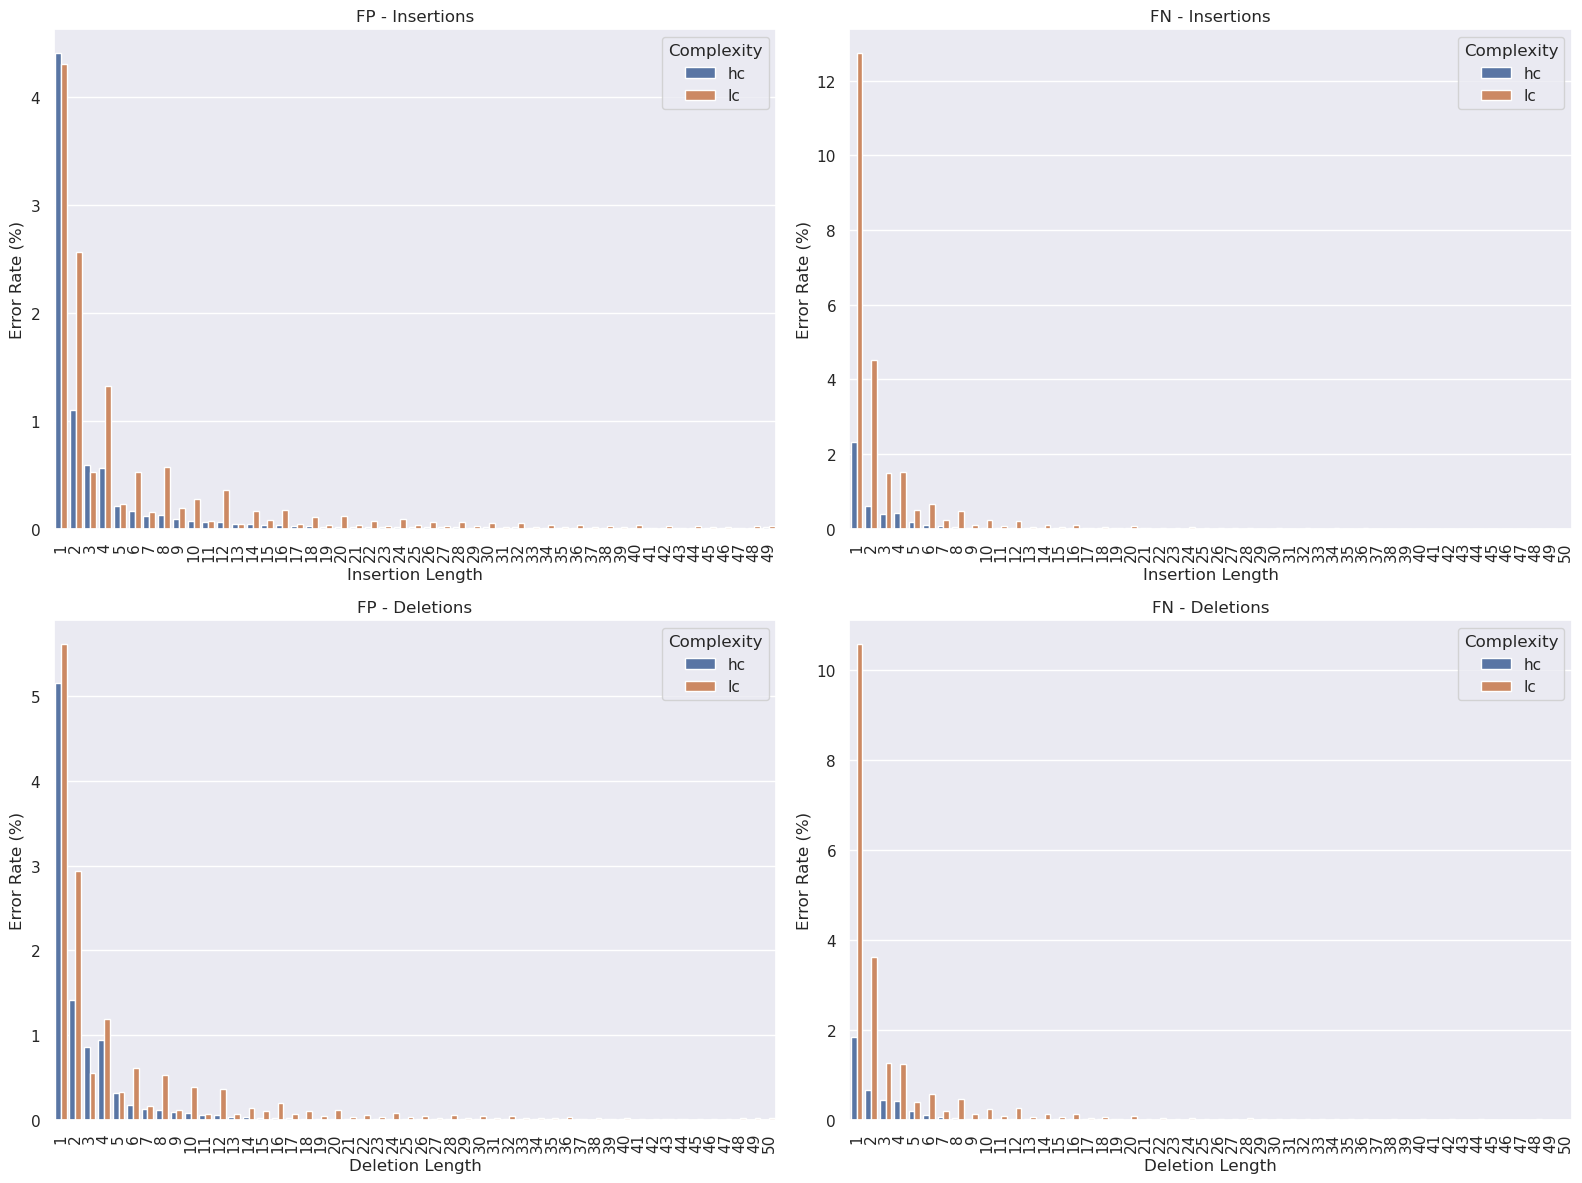

In [11]:
def preprocess_indel_data(df):
    df["Indel Length"] = df["Indel Type"].str.split("_").str[-1].astype(int)
    df["Indel Category"] = df["Indel Type"].str.split("_").str[0]
    df = df.sort_values(["Indel Category", "Indel Length", "Complexity"])
    return df


indel_plot_df = preprocess_indel_data(indel_plot_df)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for i, error_type in enumerate(["FP", "FN"]):
    for j, indel_category in enumerate(["insertion", "deletion"]):
        data = indel_plot_df[
            (indel_plot_df["Error Type"] == error_type)
            & (indel_plot_df["Indel Category"] == indel_category)
        ]

        sns.barplot(
            data=data,
            x="Indel Length",
            y="Error Rate (%)",
            hue="Complexity",
            hue_order=["hc", "lc"],
            ax=axes[j, i],
        )

        axes[j, i].set_title(f"{error_type} - {indel_category.capitalize()}s")
        axes[j, i].set_xlabel(f"{indel_category.capitalize()} Length")
        axes[j, i].set_ylabel("Error Rate (%)")

        unique_lengths = sorted(data["Indel Length"].unique())
        axes[j, i].set_xticks(range(len(unique_lengths)))
        axes[j, i].set_xticklabels(unique_lengths)

        axes[j, i].tick_params(axis="x", rotation=90)
        axes[j, i].legend(title="Complexity")

plt.tight_layout()
plt.show()
plt.close()


In [12]:
for comp, total in indel_total_variants_data.items():
    print(f"{comp.upper()}: Total indel variants = {total}")


HC: Total indel variants = 3603233
LC: Total indel variants = 12317286


In [13]:
def perform_statistical_test(
    hc_data, lc_data, hc_total, lc_total, error_type, indel_type
):
    hc_error = hc_data[error_type].get(indel_type, 0)
    lc_error = lc_data[error_type].get(indel_type, 0)

    contingency_table = [
        [hc_error, hc_total - hc_error],
        [lc_error, lc_total - lc_error],
    ]

    if any(any(cell < 5 for cell in row) for row in contingency_table):
        _, p_value = stats.fisher_exact(contingency_table)
    else:
        chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)

    return p_value


hc_data = indel_error_data["hc"]
lc_data = indel_error_data["lc"]
hc_total = indel_total_variants_data["hc"]
lc_total = indel_total_variants_data["lc"]

results = []

for error_type in ["FP", "FN"]:
    indel_types = set(hc_data[error_type].keys()) | set(lc_data[error_type].keys())

    for indel_type in indel_types:
        p_value = perform_statistical_test(
            hc_data, lc_data, hc_total, lc_total, error_type, indel_type
        )
        hc_rate = hc_data[error_type].get(indel_type, 0) / hc_total * 100
        lc_rate = lc_data[error_type].get(indel_type, 0) / lc_total * 100

        results.append(
            {
                "Error Type": error_type,
                "Indel Type": indel_type,
                "HC Rate (%)": hc_rate,
                "LC Rate (%)": lc_rate,
                "p-value": p_value,
            }
        )

results_df = pd.DataFrame(results)

_, p_values_corrected, _, _ = multipletests(results_df["p-value"], method="fdr_bh")
results_df["Adjusted p-value"] = p_values_corrected

results_df = results_df.sort_values(["Error Type", "Indel Type"])

results_df["HC Rate (%)"] = results_df["HC Rate (%)"].map("{:.4f}".format)
results_df["LC Rate (%)"] = results_df["LC Rate (%)"].map("{:.4f}".format)
results_df["p-value"] = results_df["p-value"].map("{:.4e}".format)
results_df["Adjusted p-value"] = results_df["Adjusted p-value"].map("{:.4e}".format)

results_df["Significance"] = results_df["Adjusted p-value"].apply(
    lambda x: (
        "***"
        if float(x) < 0.001
        else ("**" if float(x) < 0.01 else ("*" if float(x) < 0.05 else ""))
    )
)

print("Statistical test results for indels:")
print(results_df.to_string(index=False))


Statistical test results for indels:
Error Type   Indel Type HC Rate (%) LC Rate (%)     p-value Adjusted p-value Significance
        FN   deletion_1      1.8357     10.5674  0.0000e+00       0.0000e+00          ***
        FN  deletion_10      0.0234      0.2325  0.0000e+00       0.0000e+00          ***
        FN  deletion_11      0.0191      0.0796  0.0000e+00       0.0000e+00          ***
        FN  deletion_12      0.0143      0.2515  0.0000e+00       0.0000e+00          ***
        FN  deletion_13      0.0120      0.0586 9.1980e-276      2.8600e-275          ***
        FN  deletion_14      0.0129      0.1222  0.0000e+00       0.0000e+00          ***
        FN  deletion_15      0.0103      0.0685  0.0000e+00       0.0000e+00          ***
        FN  deletion_16      0.0070      0.1306  0.0000e+00       0.0000e+00          ***
        FN  deletion_17      0.0069      0.0292 3.3829e-127      7.4800e-127          ***
        FN  deletion_18      0.0064      0.0700  0.0000e+00    

### Size Distribution Analysis


[W::hts_idx_load3] The index file is older than the data file: output/indel/rtg_vcfeval/hc/A048_09.indel/query.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: output/indel/rtg_vcfeval/hc/A048_09.indel/truth.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: output/indel/rtg_vcfeval/hc/A085_00.indel/query.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: output/indel/rtg_vcfeval/lc/A046_12.indel/query.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: output/indel/rtg_vcfeval/lc/A046_12.indel/truth.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: output/indel/rtg_vcfeval/lc/A081_91.indel/query.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: output/indel/rtg_vcfeval/lc/A085_00.indel/query.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: output/indel/rtg_vcfeval/lc/A085_00.indel/truth.vcf.gz.tbi
[W::hts_idx_load3] The i

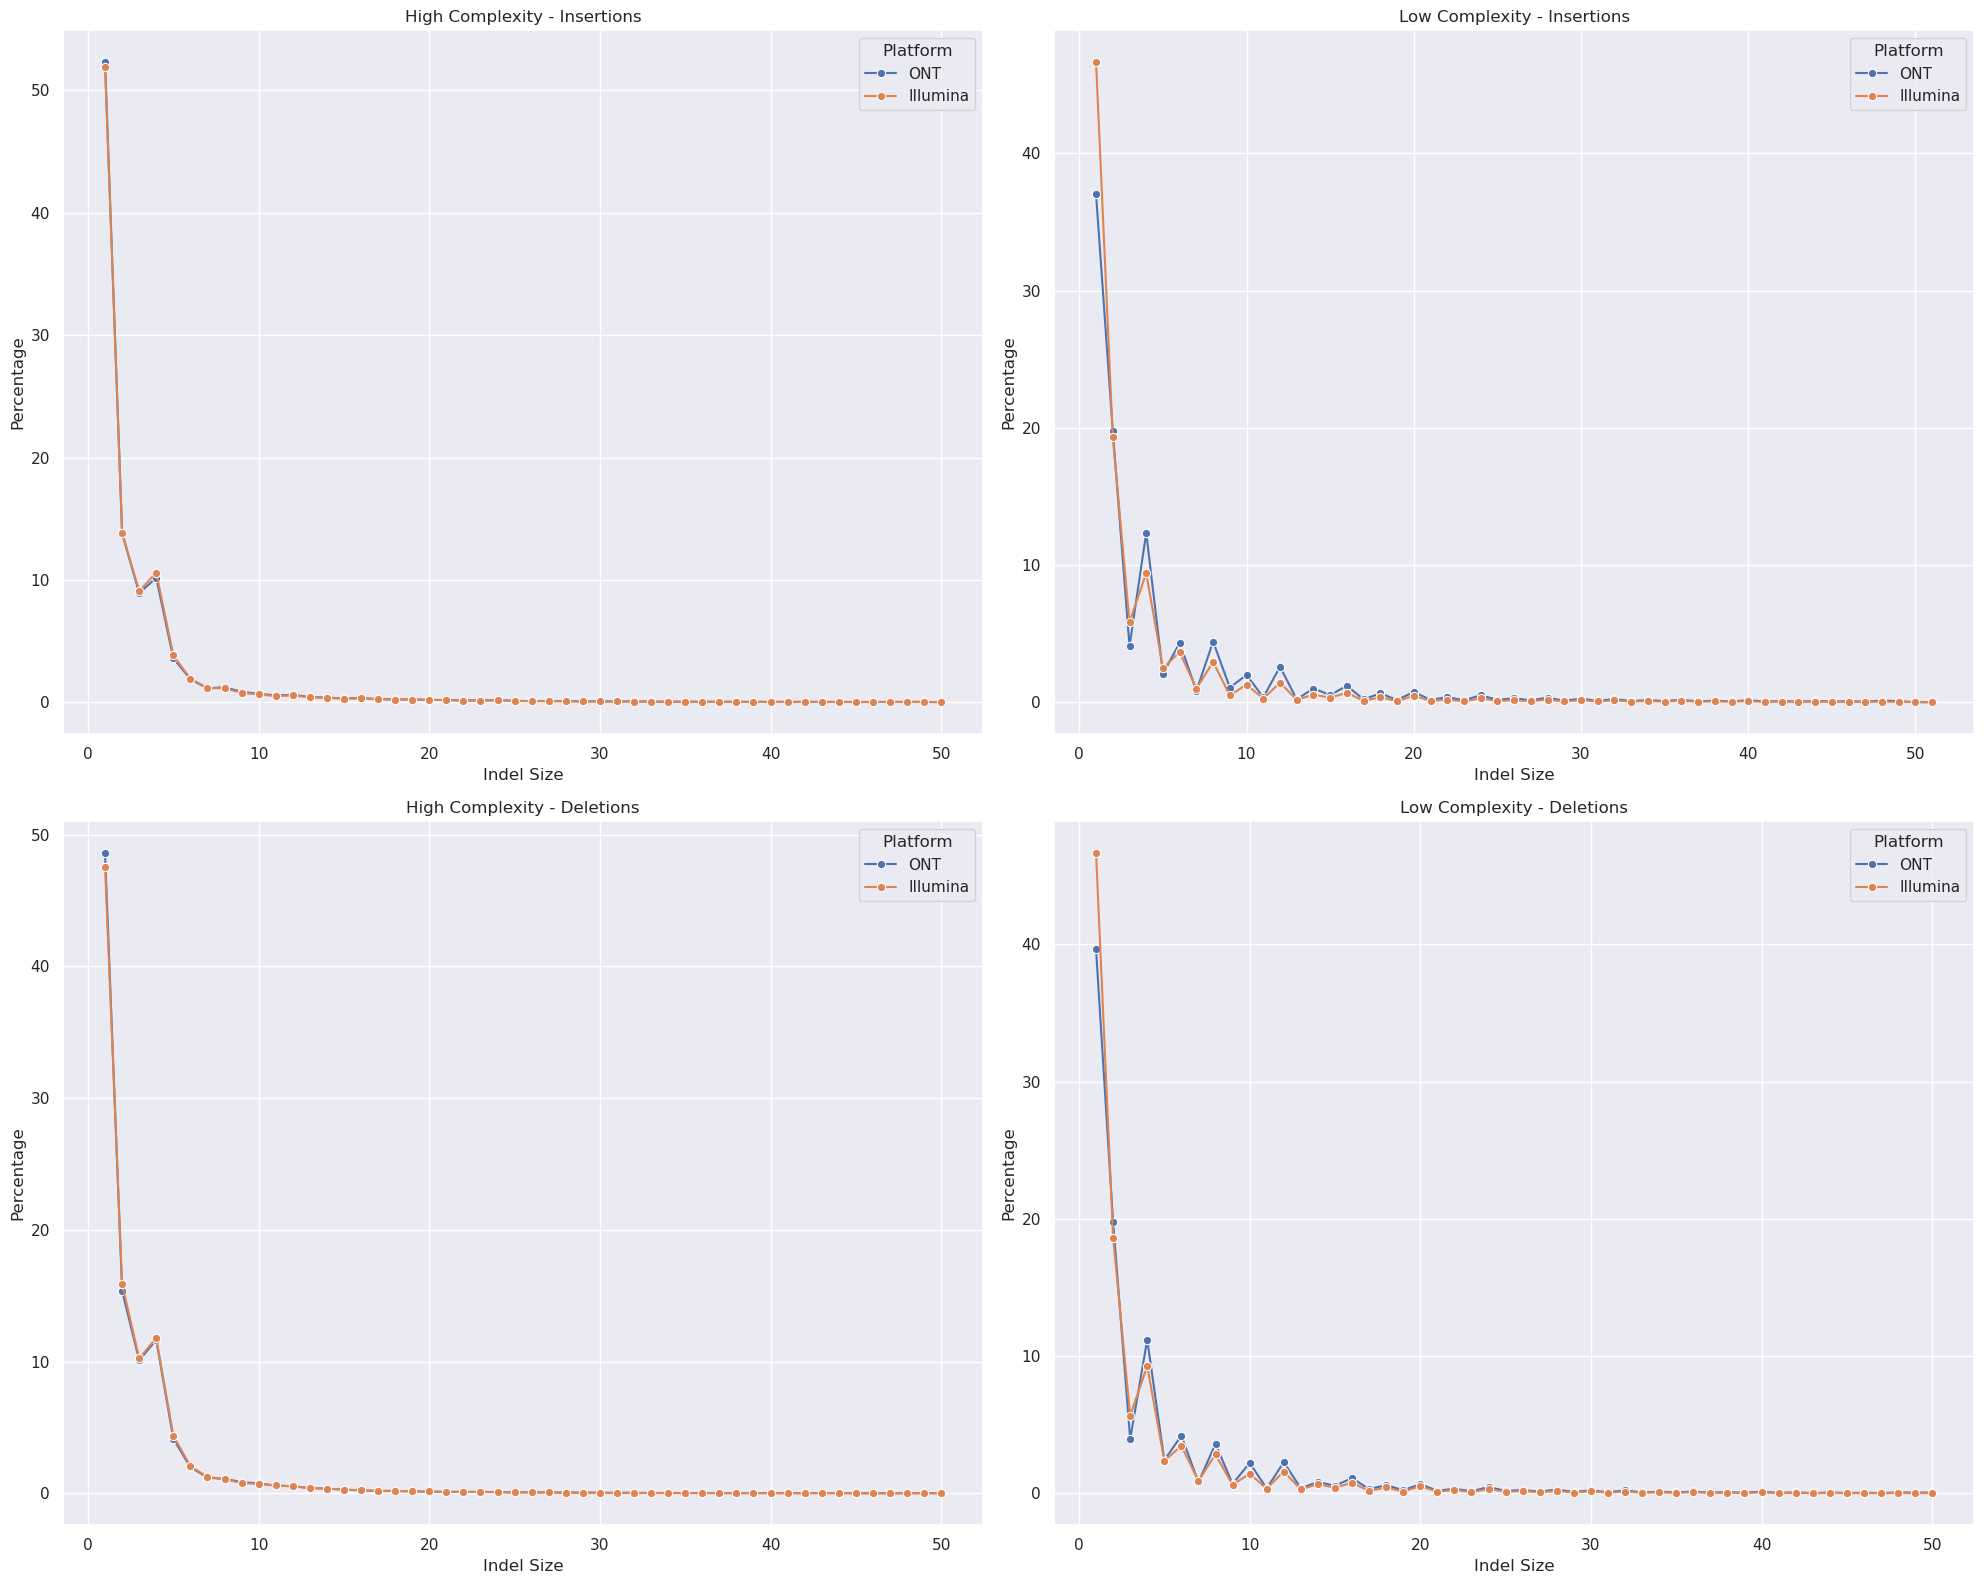

In [14]:
def analyze_indel_size_distribution(complexity, sample_ids):
    ont_sizes = defaultdict(lambda: defaultdict(int))
    illumina_sizes = defaultdict(lambda: defaultdict(int))

    for _, row in sample_ids.iterrows():
        sample_id = row["ont_id"]
        base_path = f"output/indel/rtg_vcfeval/{complexity}/{sample_id}.indel"

        query_file = os.path.join(base_path, "query.vcf.gz")
        truth_file = os.path.join(base_path, "truth.vcf.gz")

        with pysam.VariantFile(query_file) as vcf:
            for record in vcf:
                indel_type = (
                    "insertion" if len(record.alts[0]) > len(record.ref) else "deletion"
                )
                indel_length = abs(len(record.alts[0]) - len(record.ref))
                ont_sizes[indel_type][indel_length] += 1

        with pysam.VariantFile(truth_file) as vcf:
            for record in vcf:
                indel_type = (
                    "insertion" if len(record.alts[0]) > len(record.ref) else "deletion"
                )
                indel_length = abs(len(record.alts[0]) - len(record.ref))
                illumina_sizes[indel_type][indel_length] += 1

    return ont_sizes, illumina_sizes


def prepare_plot_data(ont_sizes, illumina_sizes, complexity):
    plot_data = []
    for indel_type in ["insertion", "deletion"]:
        ont_total = sum(ont_sizes[indel_type].values())
        illumina_total = sum(illumina_sizes[indel_type].values())
        max_size = max(
            max(ont_sizes[indel_type].keys()), max(illumina_sizes[indel_type].keys())
        )

        for size in range(1, max_size + 1):
            ont_percent = (
                (ont_sizes[indel_type][size] / ont_total) * 100 if ont_total > 0 else 0
            )
            illumina_percent = (
                (illumina_sizes[indel_type][size] / illumina_total) * 100
                if illumina_total > 0
                else 0
            )

            plot_data.append(
                {
                    "Indel Type": indel_type,
                    "Size": size,
                    "Percentage": ont_percent,
                    "Platform": "ONT",
                    "Complexity": complexity,
                }
            )
            plot_data.append(
                {
                    "Indel Type": indel_type,
                    "Size": size,
                    "Percentage": illumina_percent,
                    "Platform": "Illumina",
                    "Complexity": complexity,
                }
            )
    return plot_data


hc_ont_sizes, hc_illumina_sizes = analyze_indel_size_distribution("hc", sample_ids)
lc_ont_sizes, lc_illumina_sizes = analyze_indel_size_distribution("lc", sample_ids)

hc_plot_data = prepare_plot_data(hc_ont_sizes, hc_illumina_sizes, "High Complexity")
lc_plot_data = prepare_plot_data(lc_ont_sizes, lc_illumina_sizes, "Low Complexity")

plot_data = pd.DataFrame(hc_plot_data + lc_plot_data)

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
indel_types = ["insertion", "deletion"]
complexities = ["High Complexity", "Low Complexity"]

for i, indel_type in enumerate(indel_types):
    for j, complexity in enumerate(complexities):
        data = plot_data[
            (plot_data["Indel Type"] == indel_type)
            & (plot_data["Complexity"] == complexity)
        ]

        sns.lineplot(
            data=data,
            x="Size",
            y="Percentage",
            hue="Platform",
            ax=axes[i, j],
            marker="o",
        )

        axes[i, j].set_title(f"{complexity} - {indel_type.capitalize()}s")
        axes[i, j].set_xlabel("Indel Size")
        axes[i, j].set_ylabel("Percentage")
        axes[i, j].legend(title="Platform")

plt.tight_layout()
plt.show()


In [15]:
def calculate_summary_stats(sizes):
    total = sum(sizes.values())
    if total == 0:
        return {"total": 0, "mean": 0, "median": 0, "std": 0}

    sizes_array = np.array([(k, v) for k, v in sizes.items()])
    mean = np.average(sizes_array[:, 0], weights=sizes_array[:, 1])
    median = np.median(np.repeat(sizes_array[:, 0], sizes_array[:, 1].astype(int)))
    std = np.sqrt(
        np.average((sizes_array[:, 0] - mean) ** 2, weights=sizes_array[:, 1])
    )

    return {"total": total, "mean": mean, "median": median, "std": std}


print("\nSummary Statistics:")
for complexity, (ont_sizes, illumina_sizes) in [
    ("High Complexity", (hc_ont_sizes, hc_illumina_sizes)),
    ("Low Complexity", (lc_ont_sizes, lc_illumina_sizes)),
]:
    print(f"\n{complexity}")
    for indel_type in ["insertion", "deletion"]:
        ont_stats = calculate_summary_stats(ont_sizes[indel_type])
        illumina_stats = calculate_summary_stats(illumina_sizes[indel_type])

        print(f"  {indel_type.capitalize()}s:")
        print(
            f"    ONT     - Total: {ont_stats['total']}, Mean Size: {ont_stats['mean']:.2f}, Std Dev: {ont_stats['std']:.2f}, Median Size: {ont_stats['median']}"
        )
        print(
            f"    Illumina - Total: {illumina_stats['total']}, Mean Size: {illumina_stats['mean']:.2f}, Std Dev: {illumina_stats['std']:.2f}, Median Size: {illumina_stats['median']}"
        )



Summary Statistics:

High Complexity
  Insertions:
    ONT     - Total: 1629189, Mean Size: 3.17, Std Dev: 4.85, Median Size: 1.0
    Illumina - Total: 1594170, Mean Size: 3.11, Std Dev: 4.69, Median Size: 1.0
  Deletions:
    ONT     - Total: 1673477, Mean Size: 3.01, Std Dev: 4.12, Median Size: 2.0
    Illumina - Total: 1583053, Mean Size: 3.02, Std Dev: 4.08, Median Size: 2.0

Low Complexity
  Insertions:
    ONT     - Total: 3237883, Mean Size: 4.93, Std Dev: 7.01, Median Size: 2.0
    Illumina - Total: 5253849, Mean Size: 3.63, Std Dev: 5.53, Median Size: 2.0
  Deletions:
    ONT     - Total: 3734137, Mean Size: 4.70, Std Dev: 6.81, Median Size: 2.0
    Illumina - Total: 5192422, Mean Size: 3.80, Std Dev: 5.72, Median Size: 2.0


In [16]:
def compare_distributions(ont_sizes, illumina_sizes):
    ont_dist = [size for size, count in ont_sizes.items() for _ in range(count)]
    illumina_dist = [
        size for size, count in illumina_sizes.items() for _ in range(count)
    ]

    # Perform Kolmogorov-Smirnov test
    ks_statistic, p_value = stats.ks_2samp(ont_dist, illumina_dist)

    return ks_statistic, p_value


all_p_values = []
test_results = []

for complexity, (ont_sizes, illumina_sizes) in [
    ("High Complexity", (hc_ont_sizes, hc_illumina_sizes)),
    ("Low Complexity", (lc_ont_sizes, lc_illumina_sizes)),
]:
    for indel_type in ["insertion", "deletion"]:
        ks_statistic, p_value = compare_distributions(
            ont_sizes[indel_type], illumina_sizes[indel_type]
        )
        all_p_values.append(p_value)
        test_results.append((complexity, indel_type, ks_statistic, p_value))

# Perform FDR correction
_, corrected_p_values, _, _ = multipletests(all_p_values, method="fdr_bh")

print("\nStatistical Test Results (Kolmogorov-Smirnov test with FDR correction):")
for (complexity, indel_type, ks_statistic, p_value), corrected_p_value in zip(
    test_results, corrected_p_values
):
    print(f"\n{complexity} - {indel_type.capitalize()}s:")
    print(f"    KS statistic: {ks_statistic:.4f}")
    print(f"    Original p-value: {p_value:.4e}")
    print(f"    Corrected p-value: {corrected_p_value:.4e}")



Statistical Test Results (Kolmogorov-Smirnov test with FDR correction):

High Complexity - Insertions:
    KS statistic: 0.0060
    Original p-value: 2.0758e-25
    Corrected p-value: 2.0758e-25

High Complexity - Deletions:
    KS statistic: 0.0103
    Original p-value: 1.6960e-75
    Corrected p-value: 2.2613e-75

Low Complexity - Insertions:
    KS statistic: 0.1095
    Original p-value: 0.0000e+00
    Corrected p-value: 0.0000e+00

Low Complexity - Deletions:
    KS statistic: 0.0759
    Original p-value: 0.0000e+00
    Corrected p-value: 0.0000e+00


# SV Benchmark

## SV Consensus Calls


In [17]:
def read_vcf(file_path):
    svs = []
    with pysam.VariantFile(file_path) as vcf:
        for record in vcf:
            sv_type = record.info.get("SVTYPE", "Unknown")
            if sv_type == "BND":
                sv_type = "TRA"  # Classify breakends as translocations
            sv_length = record.info.get("SVLEN", 0)
            if isinstance(sv_length, tuple):
                sv_length = abs(sv_length[0]) if sv_length else 0
            else:
                sv_length = abs(sv_length)
            if sv_length == 0 and record.info.get("END"):
                sv_length = record.info["END"] - record.pos
            chrom = record.chrom
            start = record.start
            end = record.stop if record.stop else start + sv_length
            svs.append(
                {
                    "type": sv_type,
                    "length": sv_length,
                    "chrom": chrom,
                    "start": start,
                    "end": end,
                }
            )
    return pd.DataFrame(svs)


def analyze_sv_calls(sample_id, ont_id, illumina_id):
    ont_file = f"output/sv/survivor/{ont_id}/{ont_id}.ont.sv.filtered.vcf"
    illumina_file = (
        f"output/sv/survivor/{ont_id}/{illumina_id}.illumina.sv.filtered.vcf"
    )
    merged_file = f"output/sv/survivor/{ont_id}/{ont_id}_{illumina_id}_merged.vcf"

    ont_svs = read_vcf(ont_file)
    illumina_svs = read_vcf(illumina_file)
    merged_svs = read_vcf(merged_file)

    return {
        "sample_id": sample_id,
        "ont": ont_svs,
        "illumina": illumina_svs,
        "merged": merged_svs,
    }


def compare_sv_counts(sv_data):
    counts = []
    for sample_id, data in sv_data.items():
        counts.append(
            {
                "Sample": sample_id,
                "ONT": len(data["ont"]),
                "Illumina": len(data["illumina"]),
                "Merged": len(data["merged"]),
            }
        )
    return pd.DataFrame(counts)


sv_data = {}
for _, row in sample_ids.iterrows():
    sample_data = analyze_sv_calls(row["ont_id"], row["ont_id"], row["lp_id"])
    sv_data[row["ont_id"]] = sample_data

sv_counts = compare_sv_counts(sv_data)
print("SV call counts:")
sv_counts


SV call counts:


,Sample,ONT,Illumina,Merged
0,A046_12,20892,9372,4667
1,A048_09,24410,9965,5391
2,A079_07,20703,9653,4661
3,A081_91,16131,9988,3787
4,A085_00,17353,9132,3848
5,A097_92,23038,9662,5127
6,A149_01,27537,9245,5613
7,A153_01,29625,9542,6035
8,A153_06,33899,9266,6316
9,A154_04,29608,9683,5998


<Figure size 2000x1000 with 0 Axes>

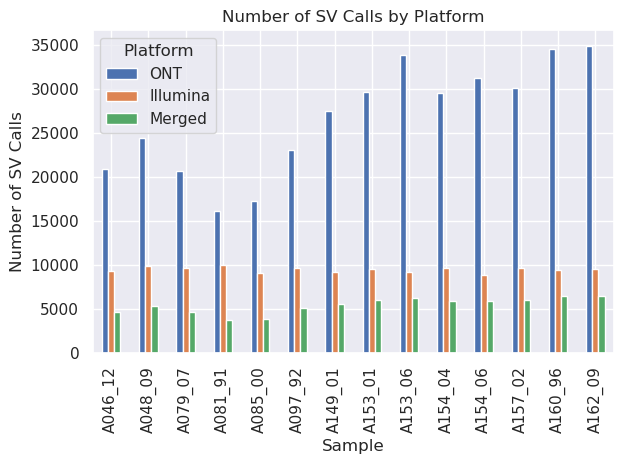

In [18]:
plt.figure(figsize=(20, 10))
sv_counts.set_index("Sample").plot(kind="bar")
plt.title("Number of SV Calls by Platform")
plt.ylabel("Number of SV Calls")
plt.legend(title="Platform")
plt.tight_layout()
plt.show()


## SV Types


In [19]:
def analyze_sv_types(sv_data):
    type_counts = defaultdict(lambda: defaultdict(int))
    for sample_id, data in sv_data.items():
        for platform in ["ont", "illumina"]:
            for sv_type, count in data[platform]["type"].value_counts().items():
                type_counts[(sample_id, platform)][sv_type] = count
    return pd.DataFrame(type_counts).T


sv_types = analyze_sv_types(sv_data)
print("\nSV type counts:")
sv_types



SV type counts:


INS      DEL   INV    TRA   DUP
A046_12 ont       11386.0   9466.0  18.0   15.0   7.0
        illumina   3289.0   5404.0   NaN  679.0   NaN
A048_09 ont       13303.0  11052.0  21.0   28.0   6.0
        illumina   3459.0   5733.0   NaN  773.0   NaN
A079_07 ont       11431.0   9244.0  12.0   11.0   5.0
        illumina   3375.0   5550.0   1.0  727.0   NaN
A081_91 ont        8843.0   7269.0   8.0    7.0   4.0
        illumina   3513.0   5661.0   1.0  813.0   NaN
A085_00 ont        9521.0   7804.0   9.0   13.0   6.0
        illumina   3067.0   5324.0   1.0  740.0   NaN
A097_92 ont       12609.0  10382.0  16.0   23.0   8.0
        illumina   3295.0   5596.0   1.0  770.0   NaN
A149_01 ont       15127.0  12328.0  21.0   49.0  12.0
        illumina   3103.0   5441.0   1.0  700.0   NaN
A153_01 ont       16163.0  13376.0  21.0   56.0   9.0
        illumina   3249.0   5486.0   1.0  806.0   NaN
A153_06 ont       18690.0  15064.0  33.0   95.0  17.0
        illumina   3115.0   5443.0   1.0  707.0   NaN
A154_04 ont       16296.0  13218.0  28.0   57.0   9.0
        illumina   3259.0   5683.0   1.0  740.0   NaN
A154_06 ont       17305.0  13896.0  28.0   70.0  11.0
        illumina   3078.0   5184.0   NaN  671.0   NaN
A157_02 ont       16543.0  13505.0  23.0   78.0  14.0
        illumina   3282.0   5574.0   1.0  795.0   NaN
A160_96 ont       19078.0  15345.0  36.0  117.0  17.0
        illumina   3195.0   5508.0   1.0  776.0   NaN
A162_09 ont       19290.0  15471.0  36.0  111.0  20.0
        illumina   3294.0   5507.0   1.0  746.0   NaN

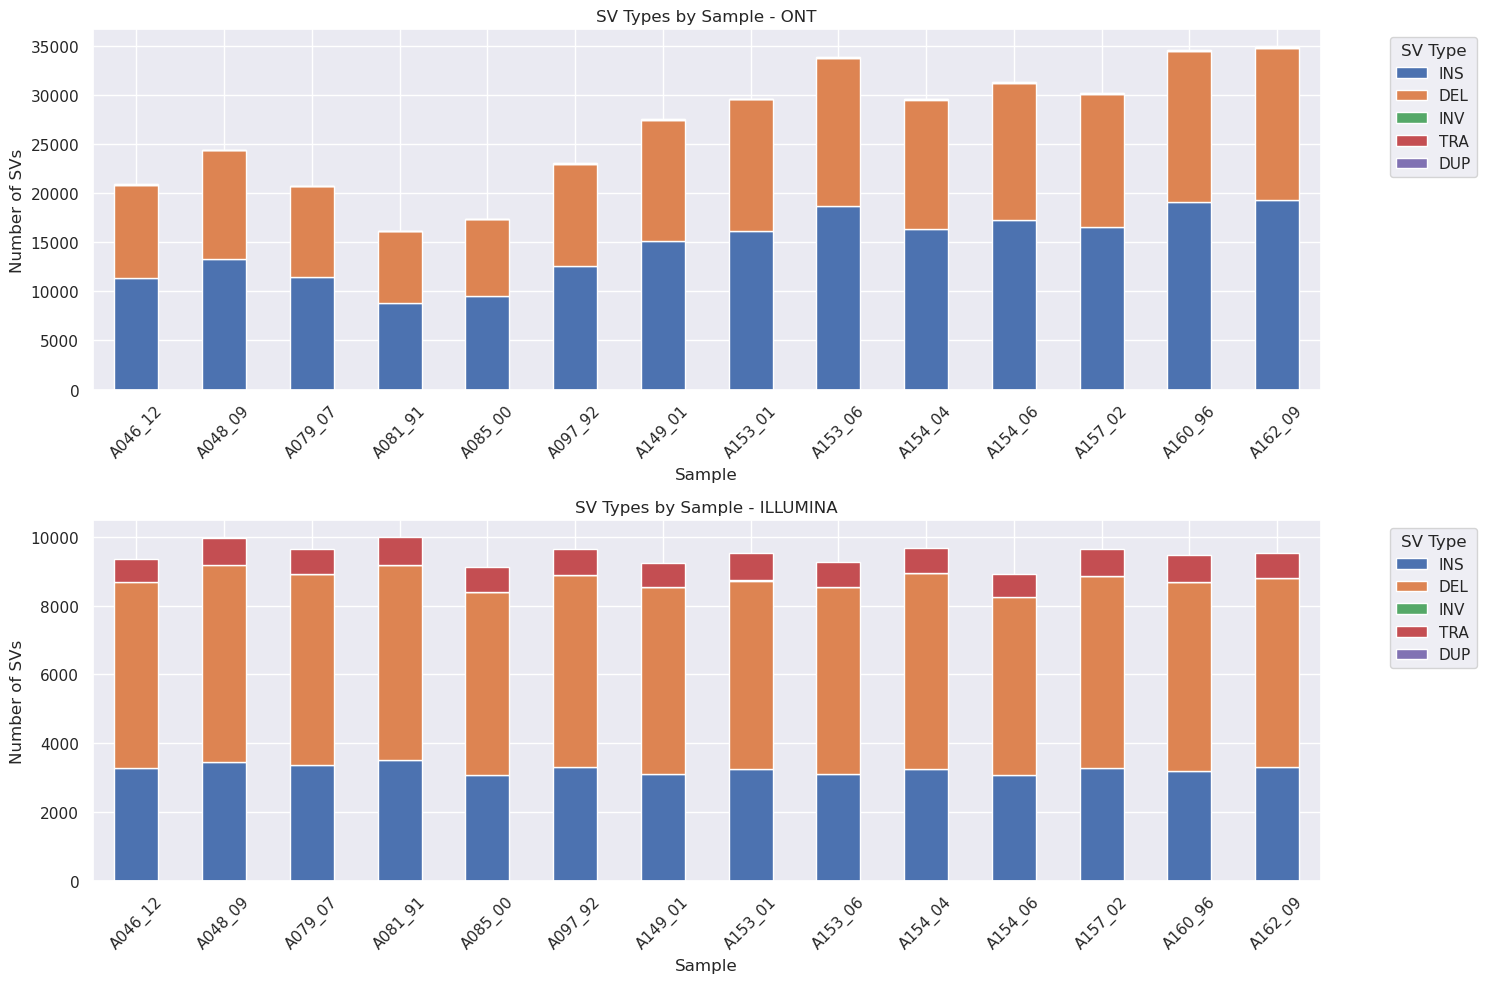

In [20]:
plt.figure(figsize=(15, 10))
for i, platform in enumerate(["ont", "illumina"]):
    plt.subplot(2, 1, i + 1)
    sv_types.xs(platform, level=1).plot(kind="bar", stacked=True, ax=plt.gca())
    plt.title(f"SV Types by Sample - {platform.upper()}")
    plt.xlabel("Sample")
    plt.ylabel("Number of SVs")
    plt.legend(title="SV Type", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## SV Size Distribution


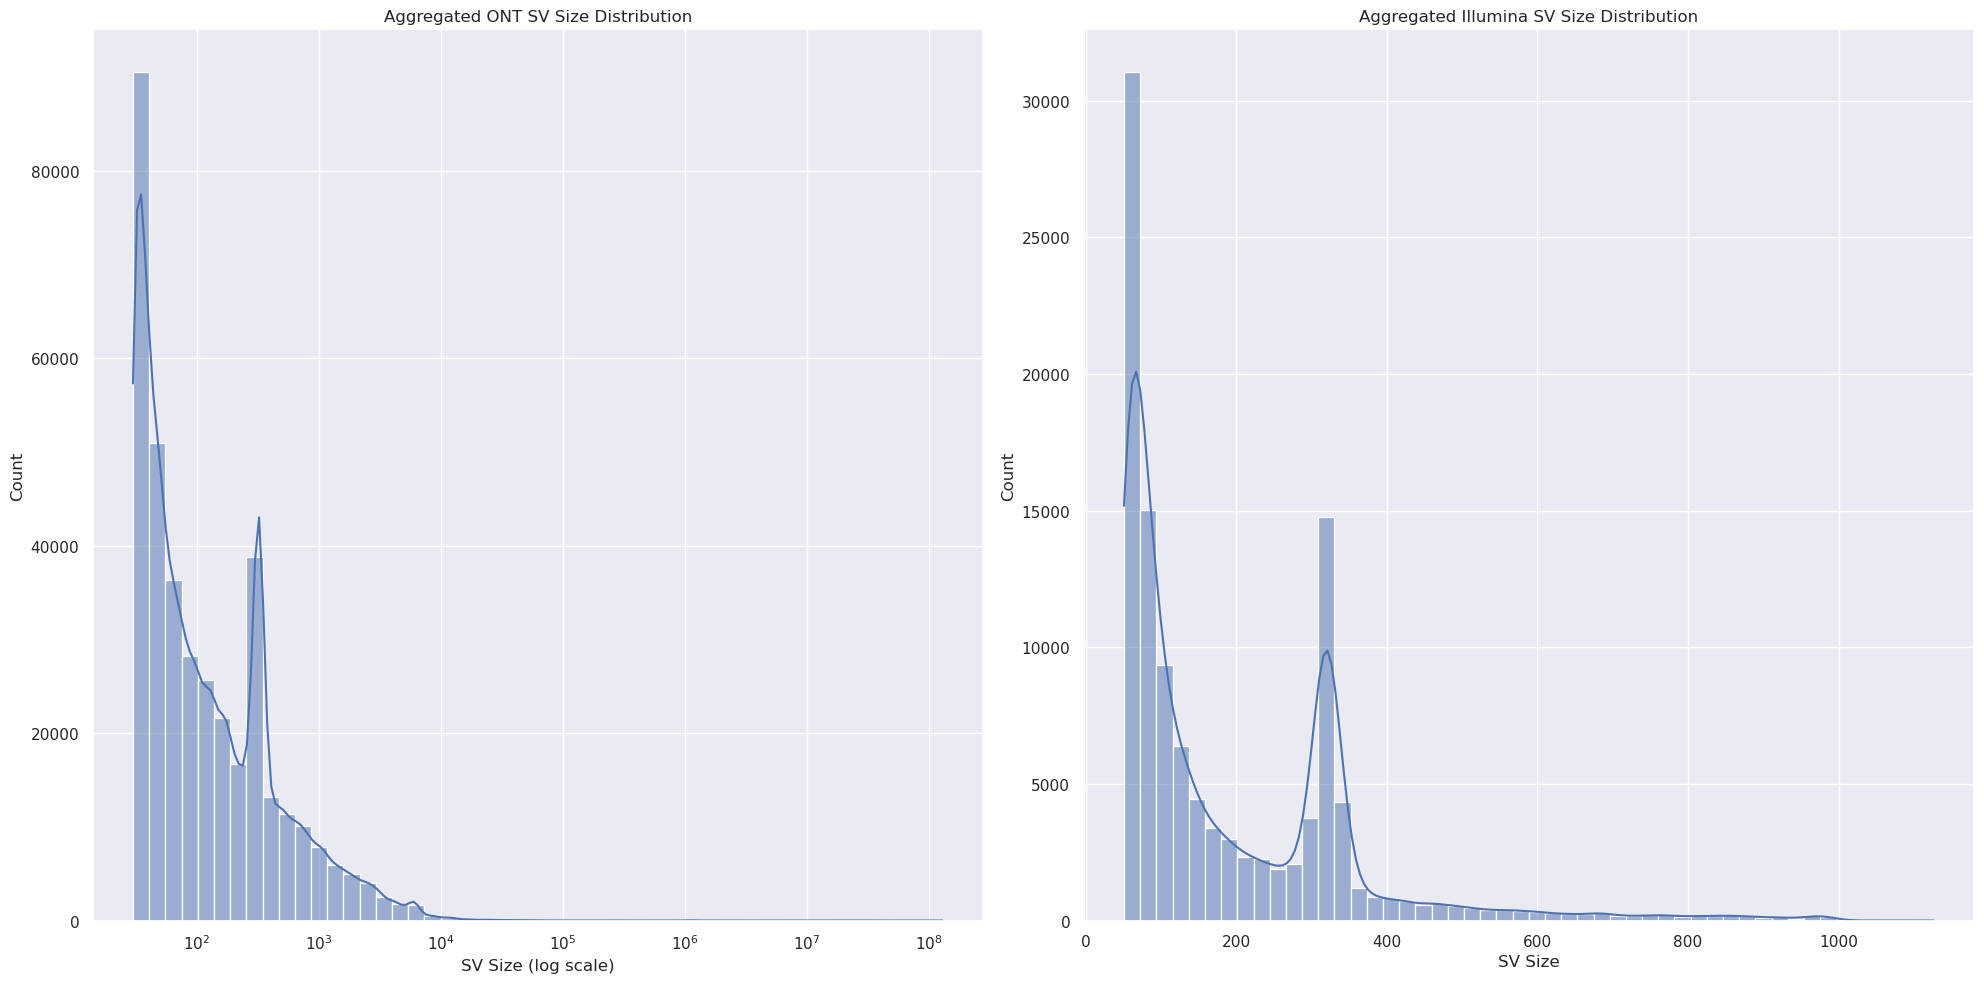

In [21]:
ont_lengths = []
illumina_lengths = []

for data in sv_data.values():
    ont_lengths.extend(data["ont"]["length"][data["ont"]["length"] > 0])
    illumina_lengths.extend(data["illumina"]["length"][data["illumina"]["length"] > 0])

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.histplot(ont_lengths, kde=True, log_scale=True, bins=50)
plt.title("Aggregated ONT SV Size Distribution")
plt.xlabel("SV Size (log scale)")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.histplot(illumina_lengths, bins=50, kde=True)
plt.title("Aggregated Illumina SV Size Distribution")
plt.xlabel("SV Size")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [22]:
print("\nSummary statistics for SVs:")
for platform, lengths in [("ONT", ont_lengths), ("ILLUMINA", illumina_lengths)]:
    print(f"  {platform}:")
    print(f"    Count: {len(lengths)}")
    print(f"    Mean: {np.mean(lengths):.2f}")
    print(f"    Median: {np.median(lengths):.2f}")
    print(f"    Min: {np.min(lengths)}")
    print(f"    Max: {np.max(lengths)}")
    print(f"    25th percentile: {np.percentile(lengths, 25):.2f}")
    print(f"    75th percentile: {np.percentile(lengths, 75):.2f}")



Summary statistics for SVs:
  ONT:
    Count: 373460
    Mean: 3889.94
    Median: 82.00
    Min: 30
    Max: 129371498
    25th percentile: 41.00
    75th percentile: 302.00
  ILLUMINA:
    Count: 114490
    Mean: 190.89
    Median: 122.00
    Min: 51
    Max: 1126
    25th percentile: 70.00
    75th percentile: 311.00


## SV Chromosomal Distribution


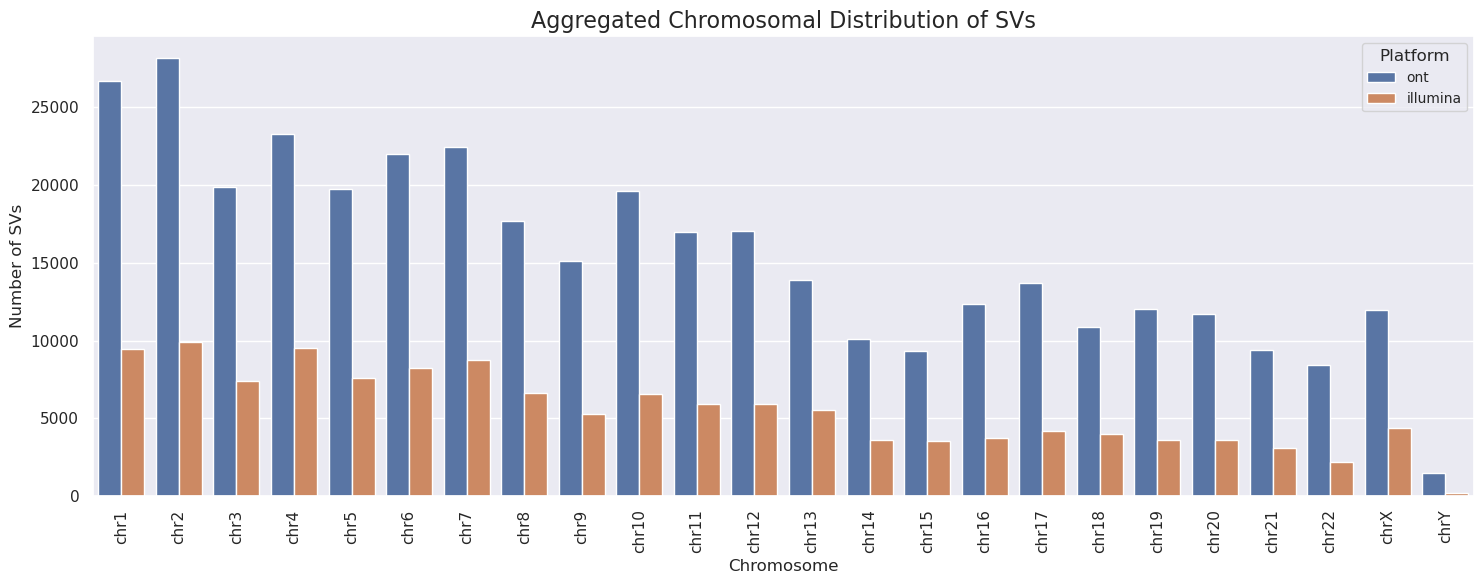

In [23]:
def analyze_chrom_distribution(sv_data):
    valid_chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
    chrom_counts = defaultdict(lambda: defaultdict(int))
    for sample_id, data in sv_data.items():
        for platform in ["ont", "illumina"]:
            for chrom in valid_chroms:
                chrom_counts[platform][chrom] += data[platform][
                    data[platform]["chrom"] == chrom
                ].shape[0]
    return pd.DataFrame(chrom_counts)


chrom_distribution = analyze_chrom_distribution(sv_data)

chrom_distribution_melted = chrom_distribution.reset_index().melt(
    id_vars="index", var_name="Platform", value_name="Count"
)
chrom_distribution_melted = chrom_distribution_melted.rename(
    columns={"index": "Chromosome"}
)

plt.figure(figsize=(15, 6))
ax = sns.barplot(
    x="Chromosome", y="Count", hue="Platform", data=chrom_distribution_melted
)

plt.title("Aggregated Chromosomal Distribution of SVs", fontsize=16)
plt.xlabel("Chromosome", fontsize=12)
plt.ylabel("Number of SVs", fontsize=12)
plt.legend(title="Platform", title_fontsize=12, fontsize=10)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()
